In [1]:
%pylab inline
import corner
from astropy.io import fits
from astropy.io import ascii
import dtdutils
reload(dtdutils)
import dtdplotutils as plot_dtd
reload(plot_dtd)
from scipy import interpolate
from scipy import stats
from scipy import misc
from scipy import integrate
import string
import emcee

Populating the interactive namespace from numpy and matplotlib


## Why randomized SFH errors are less than the statistical errors? 

The way we are calculating the posteriors from 100 random realizations of SFH gives us a posterior that has a smaller error than the posterior from the nominal SFH. This in a way seems weird. Carlos suggested using the statistical error of the nominal DTD as a lower limit. This is perhaps a quick and dirty fix. I suggested a more ambitious and probably complicated, but correct way to calculate the error. 

The idea is to treat the SFH as a nuisance parameter, and calculate the marginal likelihood. The SFH in the i'th cell and j'th bin will have a PDF, $p(\dot{M}_{ij})$ associated with it. This way, the marginal likelihood will look like :-

$$\mathcal{L}(\mathrm{data}\ |\ \Psi) = \prod_{i=1}^{N} \int \dfrac{\mathrm{e}^{-\lambda_i} \lambda_i^{n_i}}{n_i !} 
\prod_{j=1}^K p(\dot{M}_{ij}) \mathrm{d}\dot{M}_{ij}$$

where $$p(\dot{M}_{ij}) = \dfrac{1}{\sqrt{2 \pi \sigma_{ij}^2}} \mathrm{exp}\left(\dfrac{(\dot{M}_{ij} - \mu_{ij})^2}{2\sigma_{ij}^2}\right)$$ and $$\lambda_i = \sum_{j=1}^{K} \dot{M}_{ij} \Psi_j$$

**Testing**: The way to test this model is to create a simple galaxy, with suppose 4 cells and 2-3 delay-time bins. Create an SFH for each cell, and test both these methods to see what posteriors you get. The integral won't be easy though.

**Read in the SFH files for RR Lyrae in LMC, with 'Unbinned' scheme**

In [2]:
pathName = 'Output_SFH_Files/'
nCells = 808
nAgeBins = 3
objMap = np.zeros(nCells, dtype = np.int)
sfhMap = np.zeros((nAgeBins,nCells))
sfhMapMin = np.zeros((nAgeBins,nCells))
sfhMapMax = np.zeros((nAgeBins,nCells))
sfhMapRange = np.zeros((nAgeBins,nCells))
with open(pathName+'LMC_SFH_Cells_RRLyraeAll_Coarse.dat', 'r') as f:
    for cell in np.arange(nCells) :
        cellLineWords = string.split(f.readline().strip())
        objMap[cell] = float(cellLineWords[1])
        sfhMap[:,cell] = np.asarray(cellLineWords[2:]).astype(np.float)
        cellLineWords = string.split(f.readline().strip())
        sfhMapMin[:,cell] = np.asarray(cellLineWords).astype(np.float)
        cellLineWords = string.split(f.readline().strip())
        sfhMapMax[:,cell] = np.asarray(cellLineWords).astype(np.float)
        
#Check the size of the SFH array
print 'Size of SFH map: ', sfhMap.shape
print 'Size of object map: ', objMap.shape

Size of SFH map:  (3, 808)
Size of object map:  (808,)


# Mock Star-Formation History Map

In [3]:
#Number of objects per SFH cell ===> n_i
obj_array = objMap[45:49]

#SFH cells ===> M_ij
sfhmap_array = sfhMap[:, 45:49]
sfhmapmin_array = sfhMapMin[:, 45:49]
sfhmapmax_array = sfhMapMax[:, 45:49]

In [6]:
#SFH cells ===> M_ij
np.sum(sfhmap_array)*(1.0e-5)

38.336100000000002

# Rewriting the DTD Code

 Lets practice **rewriting the DTD code** here for our understanding.

In [ ]:
objMapFact = misc.factorial(obj_array)
normThreshold = 25
if obj_array.max() >= normThreshold:
    normApp = True
    normIndexes = np.where(objMap >= normThreshold)
    poissIndexes = np.where(objMap < normThreshold)
    print 'Using Normal Approximation for ', len(normIndexes[0])\
    , 'cells'
else:
    normApp = False
    normIndexes = np.array([])
    poissIndexes = np.arange(nCells)
    print 'Using Poisson Approximation'

Define the likelihood function and the priors

In [117]:
def ln_like(psi, sfhMap, objMap, objMapFact, normApp, normIndexes,\
           poissIndexes):
    l = np.dot(psi, sfhMap)
    if not normApp:
        return -1.0*np.sum(l) + np.sum(np.log((l**objMap)/objMapFact))
    else:
        likeArr = np.zeros(nCells)
        likeArr[normIndexes] = -0.5*np.log(2.0*np.pi*l) - ((objMap-l)**2.0)/(2.0*l)
        likeArr[poissIndexes] = -1.0*l + np.log((l**objMap)/objMapFact)
        return np.sum(likeArr)
    
def ln_prior(psi):
    if (psi < 0.).any(): return -np.inf
    else: return 0.
    
def ln_prob(psi, sfhMap, objMap, objMapFact, normApp, normIndexes, poissIndexes):
    lnprior = ln_prior(psi)
    if not np.isfinite(lnprior):
        return lnprior
    return lnprior + ln_like(psi, sfhMap, objMap, objMapFact, normApp, normIndexes,\
                            poissIndexes)

def plotchains(sampler):
    nParams = (sampler.chain.shape)[2]
    nWalkers = (sampler.chain.shape)[0]
    
    plt.clf()
    plt.figure(figsize=(15,15))
    
    for parameter in range(nParams):
        plt.rcParams['font.size']=14
        plt.rcParams['legend.fontsize']=14
        parName = '$\Psi_{' + str(parameter) + '}$'
        plt.subplot(nParams, 2, 2*parameter+1)
        plt.xlabel('Step')
        plt.ylabel(parName)
        for i in range(nWalkers):
            plt.semilogy(sampler.chain[i,:, parameter], color='k')
        plt.subplot(nParams, 2, 2*parameter+2)
        plt.xlabel(parName)
        plt.ylabel('N')
        plt.hist(sampler.flatchain[:,parameter], bins=20)
   
    plt.show()

**MCMC** Initialization of parameters

Initializing sampler


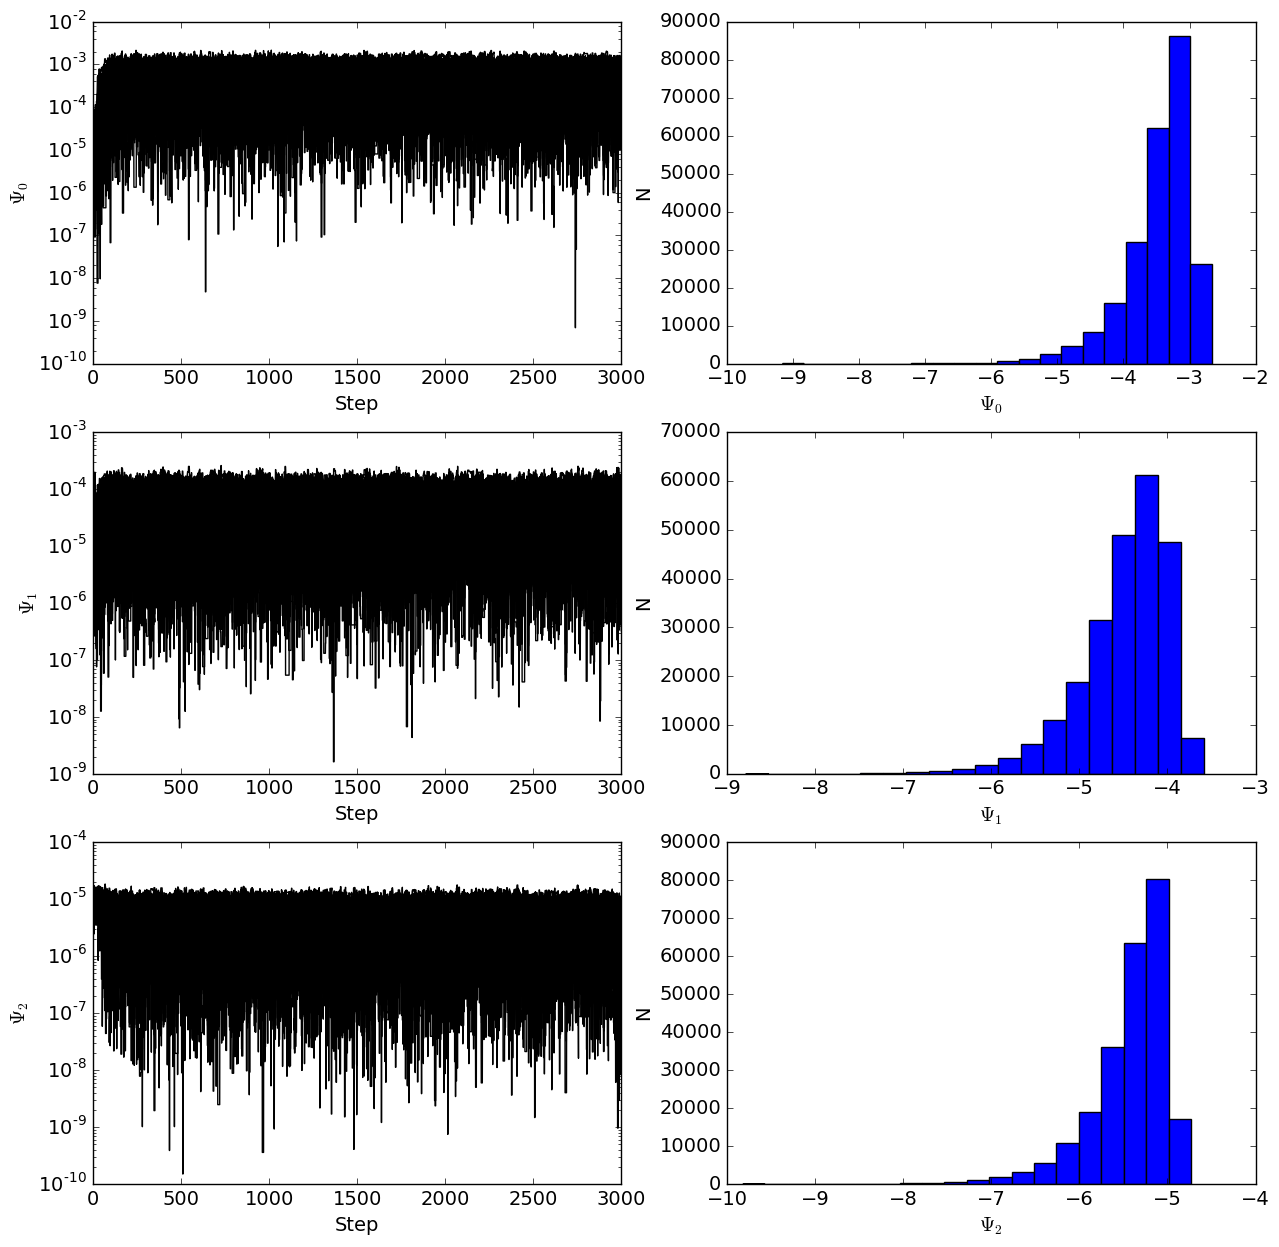

Mean Acceptance fraction during Burn-in:  0.552875


In [96]:
nWalkers = 80
nBurninSteps = 3000
log10PsiMean0 = -5.0
log10PsiSigma0 = 0.1
log10Psi0 = log10PsiSigma0*np.random.randn(nWalkers, nAgeBins) + log10PsiMean0
psi0 = np.power(10.0, log10Psi0)

#BURN-INS
print 'Initializing sampler'
sampler = emcee.EnsembleSampler(nWalkers, nAgeBins, ln_prob, args=[sfhmap_array, obj_array, objMapFact,\
                                                                  normApp, normIndexes, poissIndexes])
pos, prob, state = sampler.run_mcmc(psi0, nBurninSteps)
plotchains(sampler)

afb = np.mean(sampler.acceptance_fraction)
afbThreshold = 0.01
print 'Mean Acceptance fraction during Burn-in: ', afb
if afb < afbThreshold:
    print 'Something went wrong'
    if step == nSteps-1:
        sys.exit('End of loop')
    else:
        print 'Success!'

In [97]:
#ACTUAL CHAIN
chainLength = 3000
sampler.reset()
sampler.run_mcmc(pos, chainLength, rstate0=state)
print 'Mean acceptance fraction: ', np.mean(sampler.acceptance_fraction)

Mean acceptance fraction:  0.550466666667


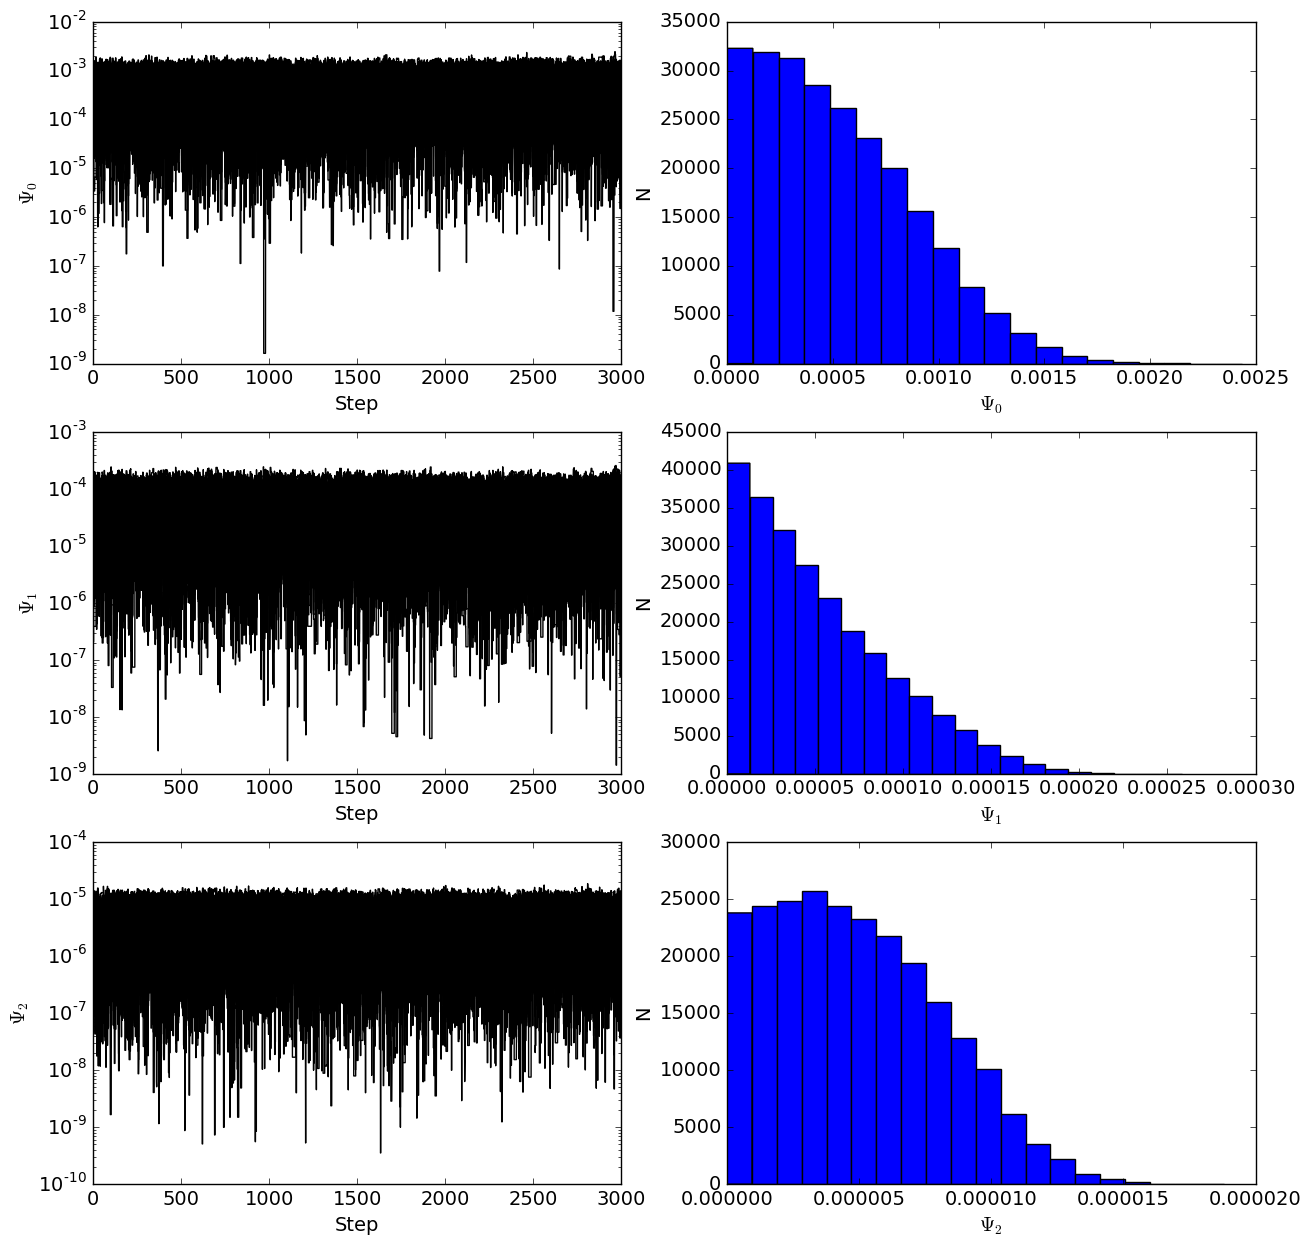

In [118]:
plotchains(sampler)

## Integrate practice with Scipy

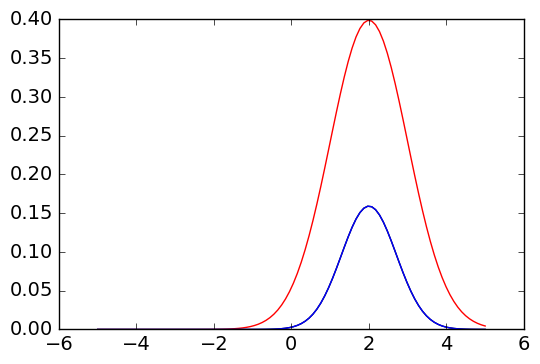

In [114]:
x = np.linspace(-5,5,100)
plt.plot(x, f(x, 2, 1), 'r-')
plt.plot(x, f(x, 2, 1)*1.0*f(x,2,1), 'k-')
plt.plot(x, f(x, 2, 1)*f(x,2,1), 'b-')
plt.show()

# 2. Rewriting the SFH code

Read in the SFH file

In [2]:
sfhFileName = 'MC_SFH_Maps/lmc_sfh.dat'
outPathName = 'Output_SFH_Files/'
print 'Reading SFH from file '+sfhFileName
nCells = 0
nAgeBins = 16
cellNames = []
cellCentersRA = []
cellCentersDec = []
sfhMap = []
with open(sfhFileName, 'r') as f:
    for i in range(17): f.readline()
    while True:
        line = f.readline() #Hyphens
        if not line : 
            print 'End of file reached after cell ', nCells
            break #Check EOF
        
        words = f.readline().split()
        cellNames.append(words[1])  #Cell name    
        #print 'Reading cell ' + cellNames[-1]
        words = f.readline().split() #Cell center
        cellCentersRA.append(float(words[1][0:2]) + float(words[2][0:2])/60.0)
        cellCentersDec.append(float(words[3][0:3]) - float(words[4][0:2])/60.0)
        line = f.readline() #Hyphens
        sfhCell = np.zeros([3,nAgeBins])
        for bin in range(nAgeBins) :
            floats = [float(x) for x in f.readline().split()]
            floatArr = np.asarray(floats)
            sfhCell[0,nAgeBins-1-bin] = floatArr[[1,4,7,10]].sum() #Best Fit
            sfhCell[1,nAgeBins-1-bin] = floatArr[[2,5,8,11]].sum() #Lower limit
            sfhCell[2,nAgeBins-1-bin] = floatArr[[3,6,9,12]].sum() #Upper limit
            f.readline() #Blank line

        sfhMap.append(sfhCell)
        nCells += 1
        
sfhMapArr = np.asarray(sfhMap)
print sfhMapArr.shape

Reading SFH from file MC_SFH_Maps/lmc_sfh.dat
End of file reached after cell  1376
(1376, 3, 16)


**So sfhMap is a (1376, 3, 16) array**. It contains SFRs for the 1376 cells, each having the best-fit, upper and lower limit for all 16 age-bins

Now we are going to look at the stellar mass formed per age-bin in a given cell, which is essentially $M_{ij} = \dot{M}_{ij} \Delta t_j$. Here $i$ is the cell index, $\Delta t_j$ is the age-interval of the $j$th age-bin of the SFH maps, and $\dot{M}_{ij}$ is the star-formation rate of cell $i$ and age-bin $j$. The DTD is then $\lambda_{i} = \sum M_{ij} \Psi_{j}$.

In [144]:
logAgeArr = np.asarray([6.8, 7.1, 7.4, 7.7, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2])
ageArr = 10.0**logAgeArr
logAgeLimsArr = np.asarray([6.65,6.95,7.25,7.55,7.85,8.1,8.3,8.5,8.7,8.9,9.1,9.3,9.5,9.7,9.9,10.1,10.3])
ageLimsArr = 10.0**logAgeLimsArr
ageIntervalsArr = ageLimsArr[1:]-ageLimsArr[:-1]

In [151]:
np.set_printoptions(suppress=False)
tot_st_mass = np.sum(np.dot(sfhMapArr[:,0,:]/1.0e6, ageIntervalsArr))/1.0e9
print 'Total LMC stellar mass (x 10^9 M_sun) = ', tot_st_mass

Total LMC stellar mass (x 10^9 M_sun) =  2.28900164723


**This is same as the cumulative stellar mass of LMC, given in Harris & Zaritsky (2009) plot in Figure 12**. The crucial factor here is the division by $10^6$, because the `lmc_sfh.dat` file has SFRs in units of $M_{\odot}/\rm{Myr}$. So I think we're fine, and the DTD spitted out is in units of objects/yr/$M_{\odot}$

**Lets look at the binned stellar mass histories**, i.e. the block of code where Carlos calculates the stellar mass per age-bins of a particular binning scheme (so $j$ is no more the native binning of `lmc_sfh.dat`). If that's calculated in 

In [158]:
binningScheme = [[0,1,2],[3,4,5],[6,7,8],[9,10],[11],[12],[13],[14,15]]
nBinsScheme = len(binningScheme)
sfhMapBinned = np.zeros((nBinsScheme, nCells))
for i, bins in enumerate(binningScheme):
    sfhMapBinned[i, :]= np.dot(sfhMapArr[:,0,bins]/1.0e6, ageIntervalsArr[bins])
    
print 'Total LMC stellar mass (x 10^9 M_sun) = ', np.sum(sfhMapBinned)/1.0e9

Total LMC stellar mass (x 10^9 M_sun) =  2.28900164723


Yup, these stellar masses are also in $M_{\odot}$, since the total stellar mass once again matches. So the DTD must be in units of $M_{\odot}/\rm{Myr}$

### 2.1 Reproducing Figure 11/12 in HZ09

HZ09 mentioned that they looked at the variances and pair-wise covariances of their SFHs, but they never mention the covariances in the table. I'm suspecting the errors listed actually taken into account the error from covariance of stellar mass between age-bins. In Figure 11, they plot the stellar mass per age bin with errors, and say the errors include the covariances between bins. To check this, lets reproduce the plot with the SFH errors from our file.

In [13]:
import SFH_Map_Diagnosis as sfhMap
reload(sfhMap)
sfhmap_allZ = sfhMap.sfhMap()
#0 - best fit, 1 - lower limit, 2 - upper limit

Reading SFH from file MC_SFH_Maps/lmc_sfh.dat
End of file reached after cell  1376


In [11]:
sfhmap_allZ.shape

(1376, 3, 16)

In [12]:
logAgeArr = np.asarray([6.8, 7.1, 7.4, 7.7, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2])
ageArr = 10.0**logAgeArr
logAgeLimsArr = np.asarray([6.65,6.95,7.25,7.55,7.85,8.1,8.3,8.5,8.7,8.9,9.1,9.3,9.5,9.7,9.9,10.1,10.3])
ageLimsArr = 10.0**logAgeLimsArr
ageIntervalsArr = ageLimsArr[1:]-ageLimsArr[:-1]

np.set_printoptions(suppress=False)
tot_st_mass = np.sum(np.dot(sfhmap_allZ[:,0,:]/1.0e6, ageIntervalsArr))/1.0e9
print 'Total LMC stellar mass (x 10^9 M_sun) = ', tot_st_mass

Total LMC stellar mass (x 10^9 M_sun) =  2.28900164723


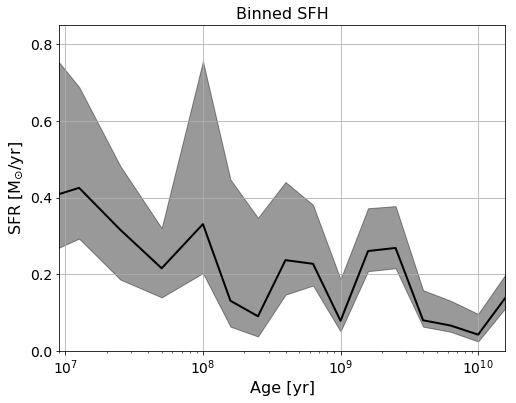

In [92]:
sfhMap_median = np.array([np.sum(sfhmap_allZ[:,0,i])*1.0e-6 for i in range(16)])
sfhMap_lowlim = np.array([np.sum(sfhmap_allZ[:,1,i])*1.0e-6 for i in range(16)])
sfhMap_uplim = np.array([np.sum(sfhmap_allZ[:,2,i])*1.0e-6 for i in range(16)])

plt.figure(figsize=(8,6))
plt.plot(ageArr, sfhMap_median, 'k-', lw=2.0)
plt.fill_between(x=ageArr, y1=sfhMap_lowlim, y2=sfhMap_uplim, color='k', alpha=0.4)
plt.xscale('log')
plt.title('Binned SFH', fontsize=16)
plt.xlabel('Age [yr]', fontsize=16)
plt.ylabel(r'SFR [M$_{\odot}$/yr]', fontsize=16)
plt.ylim(0,0.85)
plt.xlim(9.0e6, 1.58e10)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.grid()
plt.show()


[  1.74347310e-03   5.51929606e-03   1.11168148e-02   1.87477940e-02
   3.69983330e-02   4.66719591e-02   5.73004346e-02   1.01195755e-01
   1.67962429e-01   2.04712066e-01   3.96909252e-01   7.10908734e-01
   8.59956472e-01   1.05607660e+00   1.25648059e+00   2.28900165e+00]


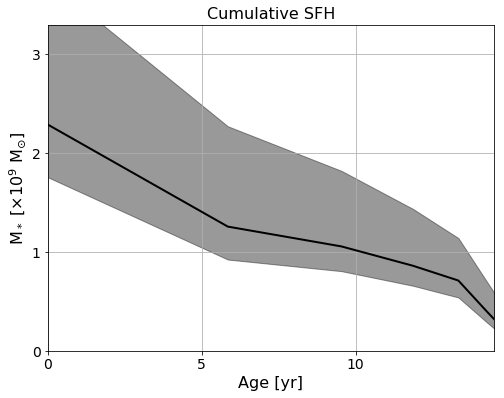

In [85]:
sfhMap_cumsum = np.cumsum(sfhMap_median*ageIntervalsArr)/1.0e9
sfhMap_lowlim_cumsum = np.cumsum(sfhMap_lowlim*ageIntervalsArr)/1.0e9
sfhMap_uplim_cumsum = np.cumsum(sfhMap_uplim*ageIntervalsArr)/1.0e9
print sfhMap_cumsum

if 1:
    plt.figure(figsize=(8,6))
    plt.plot((np.max(ageArr)/1.0e9)-(ageArr/1.0e9), sfhMap_cumsum, 'k-', lw=2.0)
    plt.fill_between(x=(np.max(ageArr)/1.0e9)-(ageArr/1.0e9), y1=sfhMap_lowlim_cumsum, y2=sfhMap_uplim_cumsum, color='k', alpha=0.4)
    plt.xlabel('Age [yr]', fontsize=16)
    #plt.ylabel(r'SFR [M$_{\odot}$/yr]', fontsize=16)
    plt.ylim(0,3.3)
    plt.xlim(0, 14.5)
    plt.title('Cumulative SFH', fontsize=16)
    plt.ylabel('M$_*$ [$\\times 10^9$ M$_{\odot}$]', fontsize=16)
    #plt.xlim(.0e6, 2.0e10)
    plt.yticks([0, 1, 2, 3])
    plt.xticks([0, 5, 10])
    plt.tick_params(axis='y', labelsize=14)
    plt.tick_params(axis='x', labelsize=14)
    plt.grid()
    plt.show()


AttributeError: 'module' object has no attribute 'reverse'

In [89]:
10**(10.2)/1.0e9

15.848931924611108